In [5]:
#importing the required libraries
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm 
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go

In [65]:
#setting up the path
train_dir = r'C:\Users\prith\Downloads\train\train'
test_dir = r'C:\Users\prith\Downloads\test1\test1'

In [9]:
#function to load and preprocess the images
def load_images (folder, img_size=(64,64), sample_count=20, label_filter=None):
    images =[]
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]
        random.shuffle(filenames)
        for img in filenames[:sample_count]:
            try:
                img_path = os.path.join(folder, img)
                img_pil = Image.open(img_path)
                img_pil = img_pil.resize(img_size)
                img_np = np.array(img_pil)/255.0
                images.append(img_np)
                labels.append(0 if 'cat' in img else 1)
            except Exception as e:
                print(f"Error Loading image{img}:{e}")

        return np.array(images),np.array(labels)

In [15]:
#visualize image with labels
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15,12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i]== 0 else 'Dog')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



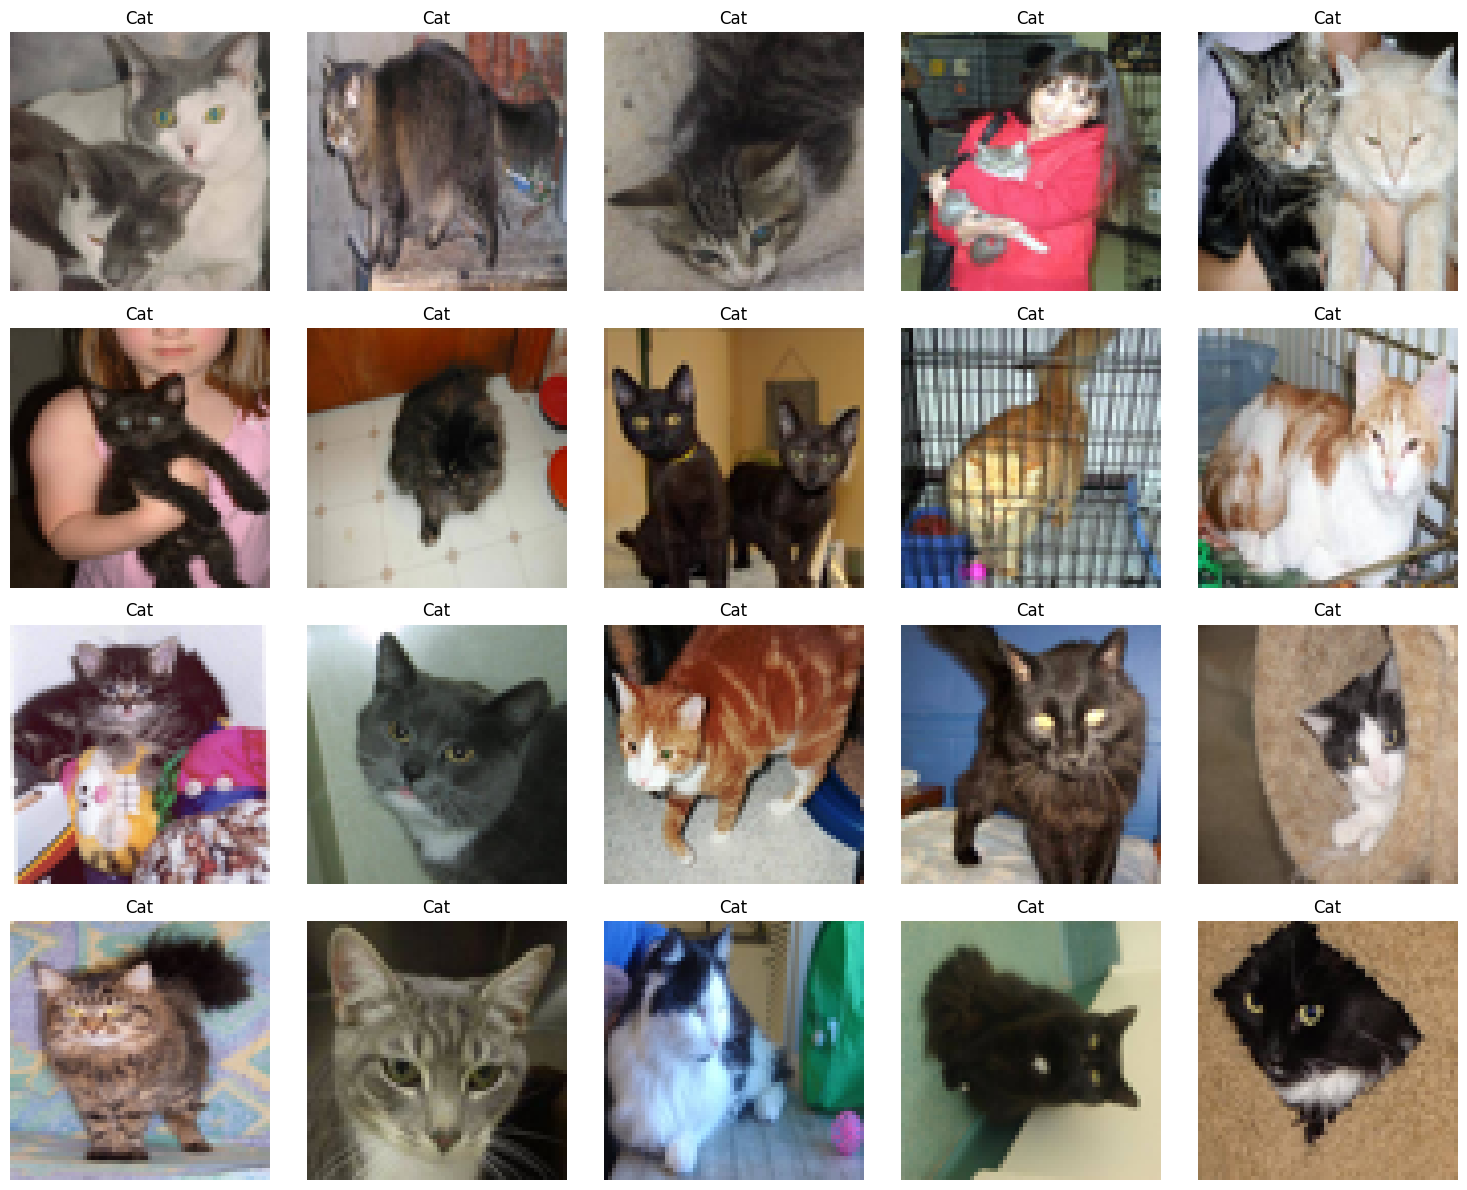

In [16]:
#load and visualize cat images
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images,cat_labels, sample_count=20)

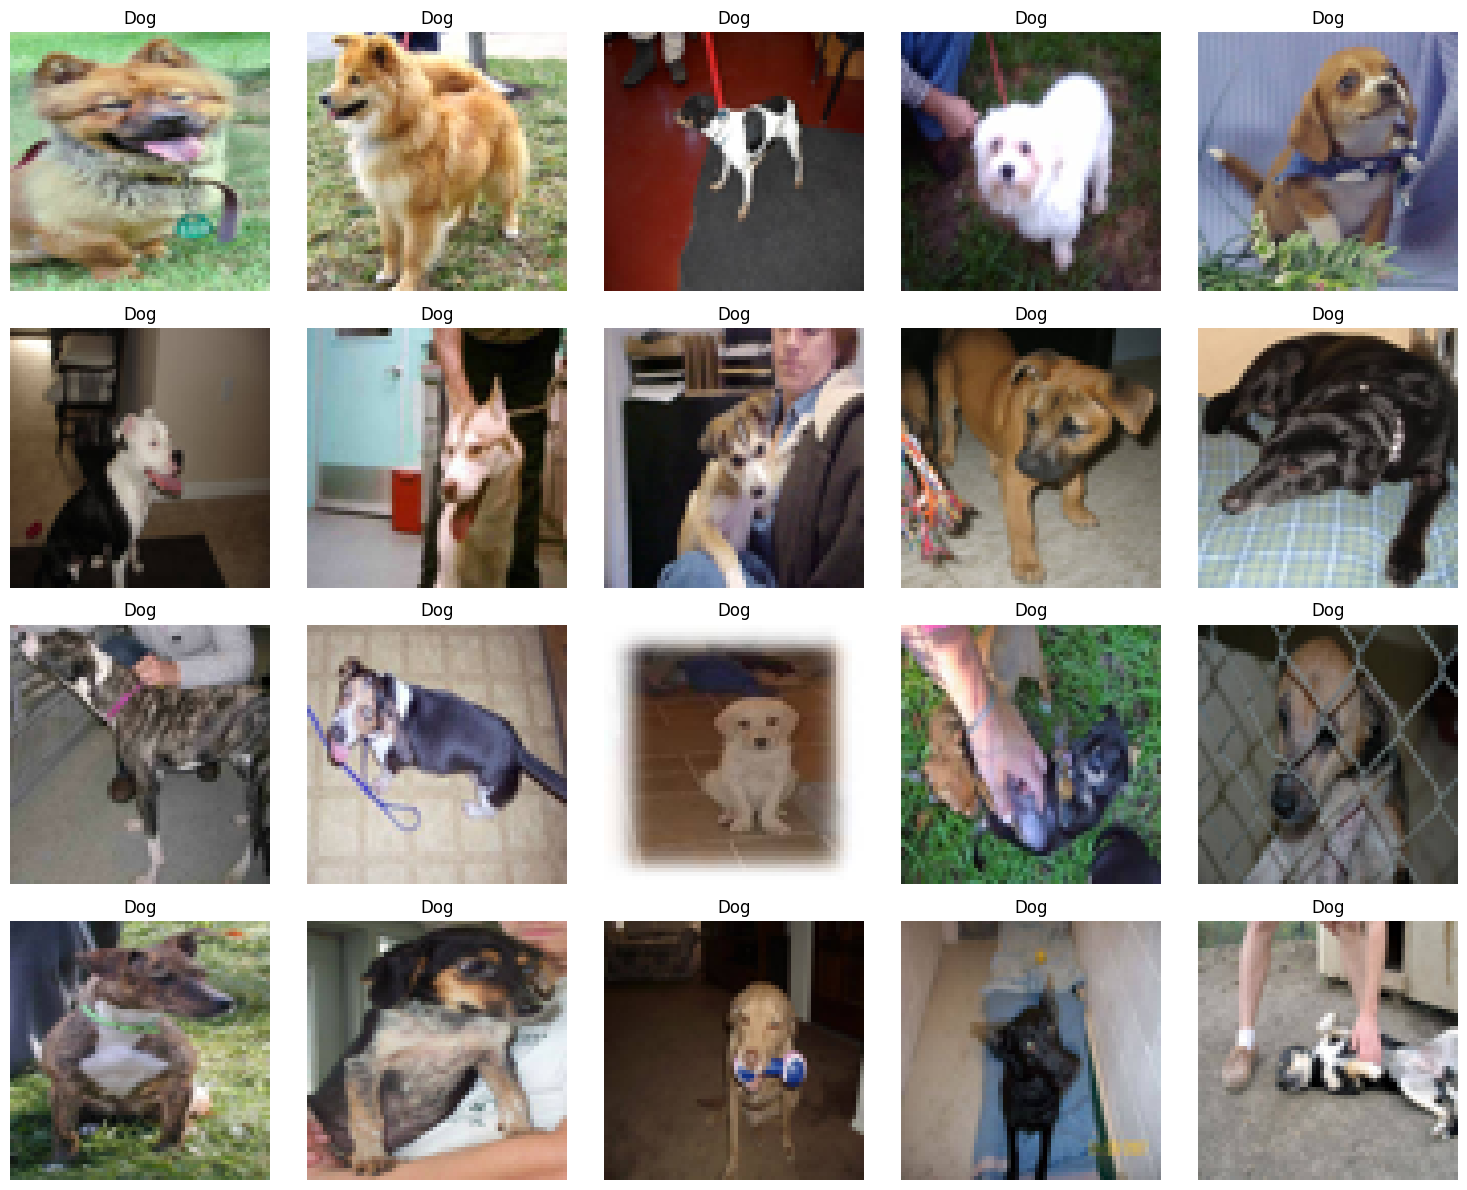

In [17]:
#load and visualize dog images
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

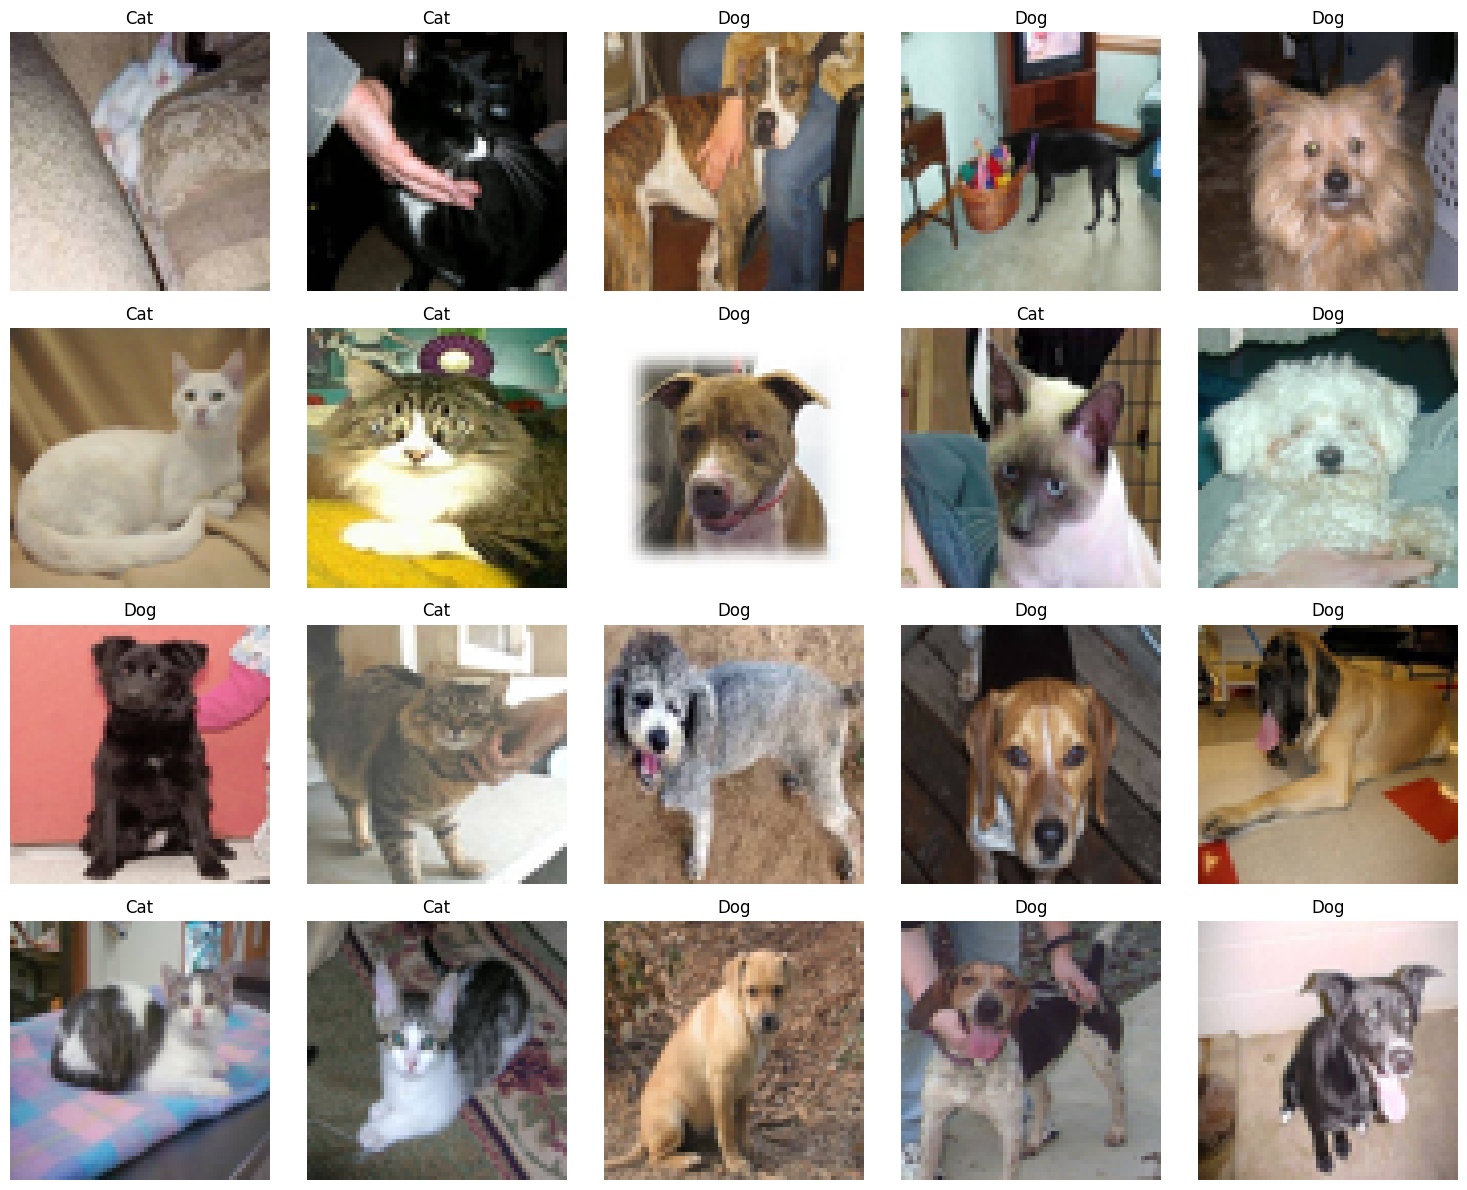

In [26]:
#load and visualize both cat and dog images
all_images, all_labels = load_images(train_dir, sample_count=20, label_filter='')
visualize_images(all_images, all_labels, sample_count=20)

In [28]:
#loading and preprocessing the training data
images, labels = load_images(train_dir,sample_count=10000, label_filter="")
images = images / 255.0

In [29]:
#display shape of images array
print("shape of iamges array:", images.shape)

shape of iamges array: (10000, 64, 64, 3)


In [31]:
#display shape of first image
print("shape of the first image:",images[0].shape)

shape of the first image: (64, 64, 3)


In [32]:
#flattening the images for the SVM input
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples,-1)

In [33]:
#standardizing the feature
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

In [44]:
#applying t-SNE
perplexity = min(30, n_samples-1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

In [45]:
#splitting the dataset into training and test sets
x_train, x_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)
x_train

array([[ 0.62442762,  0.47465846,  0.32387936, ...,  1.85777522,
         1.97981793,  1.93998945],
       [-0.03002217,  0.15900766, -0.47537268, ..., -1.72624606,
        -1.67534302, -1.54026794],
       [ 0.51061026, -0.15664315, -0.32113106, ...,  0.36812028,
        -0.21025785, -0.27738973],
       ...,
       [ 0.25452121,  0.33118082,  0.19768167, ..., -1.38701771,
        -1.31284772, -1.20252144],
       [-0.82674366, -0.67316264, -0.57352644, ..., -0.23659113,
         0.24286128, -0.04243564],
       [ 0.43947442, -0.28577302, -0.74179003, ..., -0.2808383 ,
        -0.45192138, -0.68855938]])

In [46]:
#checking class distribution
unique, counts = np.unique(labels, return_counts=True)
print(f"Class Distribution: {dict(zip(unique,counts))}")

Class Distribution: {0: 4984, 1: 5016}


In [52]:
#training SVM model
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

SVC(kernel='linear')

In [81]:
#making predictions on validation set
y_val_pred = svm.predict(x_val)
y_val_pred

In [54]:
#evaluating the model
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat','Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In [55]:

print(f"Validation accuracy: {val_accuracy: .4f}")

Validation accuracy:  0.5320


In [56]:
print(f"Classification Report: {val_class_report}")

Classification Report:               precision    recall  f1-score   support

         Cat       0.54      0.56      0.55      1011
         Dog       0.53      0.51      0.52       989

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



Confusion Matrix: [[562 449]
 [487 502]]


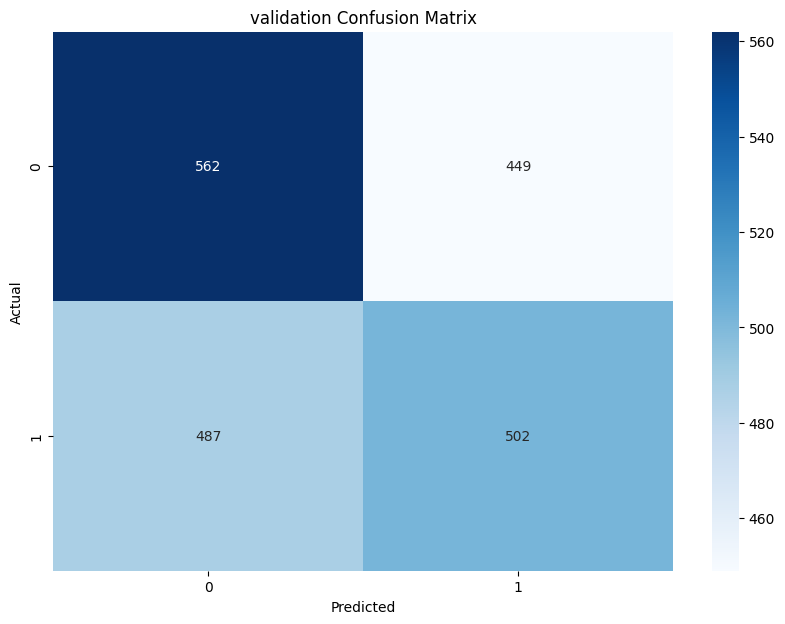

In [58]:
#confusion matrix
import seaborn as sns
print(f"Confusion Matrix: { val_conf_matrix}")
plt.figure(figsize=(10,7))
sns.heatmap(val_conf_matrix, annot = True, fmt = 'd', cmap ="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('validation Confusion Matrix')
plt.show()

In [66]:
#loading and preprocessing test data
test_images, test_labels = load_images(test_dir,label_filter='')
test_images = test_images /255.0

In [67]:
#flattening test images for SVM input
n_test_samples, test_img_height, test_img_width, test_img_channel = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat) 

In [68]:
#standardizing the features
test_images_flat_scaled = scaler.transform(test_images_flat)

In [69]:
#applying t-SNE for visualization on test data
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

In [70]:
#make predictions on test set
y_test_pred = svm.predict(test_images_flat_scaled)
y_test_pred

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])